In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GraphRAG on Google Cloud With Spanner and Vertex AI Agent Engine

|Author(s) | [Tristan Li](https://github.com/codingphun), [Smitha Venkat](https://github.com/smitha-google)

## Overview


Spanner Graph now [integrates seamlessly with LangChain](https://cloud.google.com/python/docs/reference/langchain-google-spanner/latest#spanner-graph-store-usage), making it easier to build GraphRAG applications.

Instead of simply retrieving relevant text snippets based on keyword similarity, GraphRAG takes a more sophisticated, structured approach to Retrieval Augmented Generation. It involves creating a knowledge graph from the text, organizing it hierarchically, summarizing key concepts, and then using this structured information to enhance the accuracy and depth of responses.


### Objectives

In this tutorial, you will see a complete walkthrough of building a question-answering system using the GraphRAG method. You'll learn how to create a knowledge graph from scratch, store it efficiently in Spanner Graph, a functional FAQ system with Langchain agent.

## Before you begin

1. In the Google Cloud console, on the project selector page, select or [create a Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects).
1. [Make sure that billing is enabled for your Google Cloud project](https://cloud.google.com/billing/docs/how-to/verify-billing-enabled#console).
1. [Make sure Cloud Spanner API is enabled](https://console.cloud.google.com/flows/enableapi?apiid=spanner.googleapis.com)

### Required roles

To get the permissions that you need to complete the tutorial, ask your administrator to grant you the [Owner](https://cloud.google.com/iam/docs/understanding-roles#owner) (`roles/owner`) IAM role on your project. For more information about granting roles, see [Manage access](https://cloud.google.com/iam/docs/granting-changing-revoking-access).


### Install Python Libraries

In [ ]:
%pip install --quiet json-repair==0.30.2 networkx==3.3 langchain-core==0.3.59 langchain-google-vertexai==2.0.22 langchain-experimental==0.3.4 langchain-community==0.3.24 langchain-text-splitters==0.3.8
%pip install --quiet google-cloud-resource-manager==1.13.1 pydantic==2.9.2
%pip install --quiet google-cloud-spanner==3.48.0
%pip install --quiet langchain-google-spanner==0.8.2
%pip install --quiet google-adk==0.5.0
%pip install --quiet google-cloud-aiplatform==1.91.0

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth as google_auth

    google_auth.authenticate_user()
print(sys.version)
# If using local jupyter instance, uncomment and run:
# !gcloud auth login

3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]


## Initialize and Import

In [2]:
# fmt: off
GCP_PROJECT_ID = ""  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
MODEL_NAME = "gemini-2.0-flash-001"  # @param {type:"string"}
EMBEDDING_MODEL_NAME = "text-embedding-004"  # @param {type:"string"}
TASK_TYPE = "SEMANTIC_SIMILARITY"  # @param {type:"string"}
ANSWER_TASK_TYPE = "RETRIEVAL_DOCUMENT"  # @param {type:"string"}
SPANNER_INSTANCE_ID = "graphrag-instance"  # @param {type:"string"}
SPANNER_DATABASE_ID = "graphrag"  # @param {type:"string"}
SPANNER_GRAPH_NAME = "wikigraph"  # @param {type:"string"}
# fmt: on

In [ ]:
# Set the project id
!gcloud config set project {GCP_PROJECT_ID} --quiet
%env GOOGLE_CLOUD_PROJECT={GCP_PROJECT_ID}

### Import Packages

In [4]:
import os

from langchain_core.documents import Document
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_google_vertexai import VertexAI
from langchain_text_splitters import RecursiveCharacterTextSplitter

## Create Spanner Instance and Database

To prepare for future queries, we'll now store our newly created knowledge graph in a Google Cloud Spanner database. We'll also store the accompanying embeddings in Spanner's Vector Database to enable efficient semantic search.


In [5]:
!gcloud config set project {GCP_PROJECT_ID}
!gcloud services enable spanner.googleapis.com
!gcloud spanner instances create {SPANNER_INSTANCE_ID} --config=regional-us-central1 --description="Graph RAG Instance" --nodes=1 --edition=ENTERPRISE

Updated property [core/project].


In [6]:
# prompt: create a spanner database and table to store the graph with nodes and edges created in graph


def create_database(project_id, instance_id, database_id):
    """Creates a database and tables for sample data."""
    from google.cloud import spanner
    from google.cloud.spanner_admin_database_v1.types import spanner_database_admin

    spanner_client = spanner.Client(project_id)
    database_admin_api = spanner_client.database_admin_api

    request = spanner_database_admin.CreateDatabaseRequest(
        parent=database_admin_api.instance_path(spanner_client.project, instance_id),
        create_statement=f"CREATE DATABASE `{database_id}`",
        extra_statements=[
            """CREATE TABLE KgNode (
            DocId        INT64 NOT NULL,
            Name STRING(1024),
            DOC STRING(1024),
            DocEmbedding ARRAY<FLOAT64>
            ) PRIMARY KEY (DocId)"""
        ],
    )

    operation = database_admin_api.create_database(request=request)

    print("Waiting for operation to complete...")
    OPERATION_TIMEOUT_SECONDS = 60
    database = operation.result(OPERATION_TIMEOUT_SECONDS)

    print(
        f"Created database {database.name} on instance {database_admin_api.instance_path(spanner_client.project, instance_id)}"
    )

In [ ]:
from google.cloud import spanner

create_database(GCP_PROJECT_ID, SPANNER_INSTANCE_ID, SPANNER_DATABASE_ID)

## Create a Knowledge Graph With LangChain and Gemini

These texts extracted from Wikipedia are about [Larry Page](https://en.wikipedia.org/wiki/Larry_Page), co-founder of Google. These texts will be used to create a knowledge graph about Larry Page as well as embedding vectors for semantic search.

In [8]:
text = """Lawrence Edward Page (born March 26, 1973) is an American businessman and computer scientist best known for co-founding Google with Sergey Brin.
Lawrence Edward Page was chief executive officer of Google from 1997 until August 2001 when he stepped down in favor of Eric Schmidt,
and then again from April 2011 until July 2015 when he became CEO of its newly formed parent organization Alphabet Inc.
He held that post until December 4, 2019, when he and Brin stepped down from all executive positions and day-to-day roles within the company.
He remains an Alphabet board member, employee, and controlling shareholder. Lawrence Edward Page has an estimated net worth of $156 billion as of June 2024,
according to the Bloomberg Billionaires Index, and $145.2 billion according to Forbes, making him the fifth-richest person in the world.
He has also invested in flying car startups Kitty Hawk and Opener. Like his Google co-founder, Sergey Brin, Page attended Montessori schools until he entered high school.
They both cite the educational method of Maria Montessori as the major influence in how they designed Google's work systems.
Maria Montessori believed that the liberty of the child was of utmost importance. In some sense, I feel like music training led to the high-speed legacy of Google for me"""

We will use Gemini and Langchain LLMGraphTransformer to parse the texts and generate a knowledge graph.

Leveraging Gemini's capabilities, Langchain will use them to identify and extract key information from the text, such as people, countries, and their nationalities, to construct a comprehensive knowledge graph from the texts based on the nodes and relationships we define.

In [9]:
documents = [Document(page_content=text)]

llm = VertexAI(model_name=MODEL_NAME, project=GCP_PROJECT_ID, location=REGION)

llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization", "Asset"],
    allowed_relationships=[
        "NATIONALITY",
        "LOCATED_IN",
        "WORKED_AT",
        "SPOUSE",
        "NET_WORTH",
        "INVESTMENT",
        "INFLUENCED_BY",
    ],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)

## Store the Knowledge Graph in Spanner

Now that the Spanner database is created, we will store the Knowledge Graph in the Spanner Graph Store

In [10]:
from langchain_google_spanner import SpannerGraphStore

graph_store = SpannerGraphStore(
    instance_id=SPANNER_INSTANCE_ID,
    database_id=SPANNER_DATABASE_ID,
    graph_name=SPANNER_GRAPH_NAME,
)

In [11]:
# Uncomment the line below, if you want to cleanup from previous iterations.
# BeWARE - THIS COULD REMOVE DATA FROM YOUR DATABASE !!!
graph_store.cleanup()

for graph_document in graph_documents_filtered:
    graph_store.add_graph_documents([graph_document])

Waiting for DDL operations to complete...
Waiting for DDL operations to complete...
Insert nodes of type `Asset`...
Insert nodes of type `Organization`...
Insert nodes of type `Person`...
Insert nodes of type `Country`...
Insert edges of type `Person_WORKED_AT_Organization`...
Insert edges of type `Person_NATIONALITY_Country`...
Insert edges of type `Person_NET_WORTH_Asset`...
Insert edges of type `Person_INVESTMENT_Organization`...
Insert edges of type `Person_INFLUENCED_BY_Person`...


## Build a QnA Agent

Let's build a QnA agent and ask quick questions

In [12]:
from langchain_google_spanner import SpannerGraphQAChain
from langchain_google_vertexai import ChatVertexAI

# Initialize llm object
llm = ChatVertexAI(model=MODEL_NAME, temperature=0)

# Initialize GraphQAChain
chain = SpannerGraphQAChain.from_llm(
    llm,
    graph=graph_store,
    allow_dangerous_requests=True,
    verbose=False,
    return_intermediate_steps=True,
)

In [13]:
# fmt: off
question = "What businesses does Lawrence Edward Page invest in?"  # @param {type:"string"}
# fmt: on
response = chain.invoke("query=" + question)
response["result"]

'Lawrence Edward Page invests in Kitty Hawk and Opener.\n'

**Important: Magic cell below only works on Colab**

In [ ]:
%%spanner_graph --project {GCP_PROJECT_ID} --instance {SPANNER_INSTANCE_ID} --database {SPANNER_DATABASE_ID}

GRAPH wikigraph
MATCH p = (a)-[e]->(b)
RETURN TO_JSON(p) AS path_json
LIMIT 50

## Enhance Search Capability

Now if we rephrase the question with "Larry Page" instead of his legal name " Lawrence Edward Page", it would fail because it relies on exact keyword matching. Semantic search, using embeddings and vector search, overcomes this by understanding the meaning and relationships between words, thus recognizing both names refer to the same person! On the flip side, if we only use semantic search with vector similarity search, the results returned are not always accurate. See examples below on the challenges of either approach.

#### Generate the embeddings

In [14]:
import json

import vertexai
from vertexai.generative_models import GenerationConfig, GenerativeModel
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel

# init the vertexai package
vertexai.init(project=GCP_PROJECT_ID, location=REGION)


def get_embedding(text, task_type, model):
    try:
        text_embedding_input = TextEmbeddingInput(task_type=task_type, text=text)
        embeddings = model.get_embeddings([text_embedding_input])
        return embeddings[0].values
    except:
        return []


embedding_model = TextEmbeddingModel.from_pretrained(EMBEDDING_MODEL_NAME)
text_model = GenerativeModel(MODEL_NAME)
documents = [Document(page_content=text)]

spanner_embedding_values = []

from langchain.text_splitter import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=500, chunk_overlap=100, separators=["\n\n", "\n", r"(?<=\. )", " ", ""]
)
splitted_text = splitter.split_documents(documents)
for chunk in splitted_text:
    chunk_content = chunk.page_content
    embedding = get_embedding(chunk_content, ANSWER_TASK_TYPE, embedding_model)
    user_prompt_content = (
        "Find person's names but ignore any pronoun in the following sentence \n"
        + chunk_content
    )
    response = text_model.generate_content(
        user_prompt_content,
        generation_config=GenerationConfig(
            temperature=0,
            response_mime_type="application/json",
            response_schema={
                "type": "OBJECT",
                "properties": {"nodes": {"type": "STRING"}},
            },
        ),
    )
    response_content = json.loads(response.candidates[0].content.parts[0].text)["nodes"]
    print(embedding[:10], chunk_content[:10], response_content)
    spanner_embedding_values.append([embedding, chunk_content, response_content])

[0.04362960532307625, -0.015628624707460403, -0.03651438280940056, 0.07635214179754257, 0.025854211300611496, 0.016094792634248734, 0.032845646142959595, -0.025009311735630035, 0.033768218010663986, 0.0557292141020298] Lawrence E Lawrence Edward Page, Sergey Brin, Eric Schmidt
[0.05250556766986847, 0.0059433588758111, -0.053659338504076004, 0.0366397500038147, 0.027847468852996826, 0.006960400380194187, 0.0055380454286932945, -0.03739484027028084, 0.05096553638577461, 0.06589022278785706] He held th Brin, Lawrence Edward Page
[0.00012151900591561571, -0.04247371852397919, -0.06008194014430046, 0.08208870142698288, 0.022667380049824715, 0.015254673548042774, 0.03223690763115883, -0.016212889924645424, 0.02410755306482315, 0.021432554349303246] He has als Sergey Brin, Page, Maria Montessori


#### Knowledge graph search only - no result found

In [15]:
# fmt: off
question = "What businesses does Larry Page invest in?"  # @param {type:"string"}
# fmt: on
response = chain.invoke("query=" + question)
response["result"]

"I don't know the answer."

#### Semantic search only - top similarity match is incorrect

In [16]:
from sklearn.metrics.pairwise import cosine_similarity

# fmt: off
QUESTION = "What businesses does Larry Page invest in?"  # @param {type:"string"}
# fmt: on

q_emb = get_embedding(QUESTION, ANSWER_TASK_TYPE, embedding_model)

for emb in spanner_embedding_values:
    print(f"chunk: {emb[1]} \n similarity: {cosine_similarity([q_emb], [emb[0]])} \n")

chunk: Lawrence Edward Page (born March 26, 1973) is an American businessman and computer scientist best known for co-founding Google with Sergey Brin.
Lawrence Edward Page was chief executive officer of Google from 1997 until August 2001 when he stepped down in favor of Eric Schmidt,
and then again from April 2011 until July 2015 when he became CEO of its newly formed parent organization Alphabet Inc. 
 similarity: [[0.78622893]] 

chunk: He held that post until December 4, 2019, when he and Brin stepped down from all executive positions and day-to-day roles within the company.
He remains an Alphabet board member, employee, and controlling shareholder. Lawrence Edward Page has an estimated net worth of $156 billion as of June 2024,
according to the Bloomberg Billionaires Index, and $145.2 billion according to Forbes, making him the fifth-richest person in the world. 
 similarity: [[0.81792139]] 

chunk: He has also invested in flying car startups Kitty Hawk and Opener. Like his Google

#### Save the embeddings into Spanner

In [17]:
spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)


def insert_values(transaction):
    value1 = 0
    for sub_list in spanner_embedding_values:
        table_name = "KgNode"
        col_name1 = "docID"
        col_name2 = "Name"
        col_name3 = "Doc"
        col_name4 = "DocEmbedding"
        value1 += 1
        value2 = sub_list[2]
        value3 = sub_list[1]
        value4 = sub_list[0]
        # print(col_name1, col_name2, col_name3, col_name4, value1, value2, value3, value4[:10])
        row_ct1 = transaction.execute_update(
            f"INSERT INTO {table_name} ({col_name1}, {col_name2}, {col_name3}, {col_name4}) VALUES (@value1, @value2, @value3, @value4)",
            params={
                "value1": value1,
                "value2": value2,
                "value3": value3,
                "value4": value4,
            },
            param_types={
                "value1": spanner.param_types.INT64,
                "value2": spanner.param_types.STRING,
                "value3": spanner.param_types.STRING,
                "value4": spanner.param_types.Array(spanner.param_types.FLOAT64),
            },
        )  # Adjust types if needed

        print(f"{row_ct1} record(s) inserted.")


# print(insert_values)  # This just prints the function object, remove this line
database.run_in_transaction(insert_values)

1 record(s) inserted.
1 record(s) inserted.
1 record(s) inserted.


#### Combine both semantic search and graph search. Ask the question again - correct answer!


In [19]:
import json

import vertexai
from vertexai.generative_models import GenerationConfig, GenerativeModel
from vertexai.language_models import TextEmbeddingModel

# fmt: off
QUESTION = "What businesses does Larry Page invest in?"  # @param {type:"string"}
# fmt: on
q_emb = get_embedding(QUESTION, TASK_TYPE, embedding_model)

spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)
kgnodename = ""
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        """SELECT DocId, NAME, Doc FROM KgNode ORDER BY COSINE_DISTANCE(DocEmbedding, @q_emb) limit 1""",
        params={"q_emb": q_emb},
        param_types={
            "q_emb": spanner.param_types.Array(spanner.param_types.FLOAT64)
        },  # Adjust FLOAT64 if needed
    )
    for row in results:
        kgnodename = str(row[1])

text_model = GenerativeModel(MODEL_NAME)
user_prompt_content = (
    "Find and replace entities such as person's name, place, nationality in the following sentence \n"
    + QUESTION
    + "with entities defined below \n"
    + kgnodename
    + "\n only replace matching person's name \n output the best replacement in a string"
)
# print (user_prompt_content)
response = text_model.generate_content(
    user_prompt_content,
    generation_config=GenerationConfig(
        temperature=0,
        response_mime_type="application/json",
        response_schema={
            "type": "OBJECT",
            "properties": {"sentence": {"type": "STRING"}},
        },
    ),
)
response_content = json.loads(response.candidates[0].content.parts[0].text)["sentence"]
print(response_content)
response = chain.invoke("query=" + response_content)
response["result"]

What businesses does Lawrence Edward Page invest in?


'Lawrence Edward Page invests in Kitty Hawk and Opener.\n'

## Agent Development Kit

The [Agent Development Kit (ADK)](https://google.github.io/adk-docs/) is a flexible, modular framework for developing and deploying AI agents, designed to be model-agnostic, deployment-agnostic, and compatible with other frameworks, despite its optimization for Gemini and the Google ecosystem.


In [20]:
import json

import vertexai
from google.adk.agents import Agent
from google.cloud import spanner
from langchain_google_spanner import SpannerGraphStore
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
)
from vertexai.language_models import TextEmbeddingModel

os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "1"
os.environ["GOOGLE_CLOUD_PROJECT"] = GCP_PROJECT_ID
os.environ["GOOGLE_CLOUD_LOCATION"] = REGION

#### Create helper functions for function calling

We will create a couple python functions for function calling for the agent. The first function is to generate embeddings of the user query. The second function is to query the Spanner database combining both semantic search and graph search.

In [21]:
def ask_graph(query: str) -> dict:
    from google.cloud import spanner
    from langchain_google_spanner import SpannerGraphQAChain, SpannerGraphStore
    from langchain_google_vertexai import ChatVertexAI

    GCP_PROJECT_ID = ""
    REGION = "us-central1"
    MODEL_NAME = "gemini-2.0-flash-001"
    EMBEDDING_MODEL_NAME = "text-embedding-004"
    TASK_TYPE = "SEMANTIC_SIMILARITY"
    SPANNER_INSTANCE_ID = "graphrag-instance"
    SPANNER_DATABASE_ID = "graphrag"
    SPANNER_GRAPH_NAME = "wikigraph"

    graph_store = SpannerGraphStore(
        instance_id=SPANNER_INSTANCE_ID,
        database_id=SPANNER_DATABASE_ID,
        graph_name=SPANNER_GRAPH_NAME,
    )

    # Initialize llm object
    llm = ChatVertexAI(model=MODEL_NAME, temperature=0)

    # Initialize GraphQAChain
    chain = SpannerGraphQAChain.from_llm(
        llm,
        graph=graph_store,
        allow_dangerous_requests=True,
        verbose=False,
        return_intermediate_steps=True,
    )

    embedding_model = TextEmbeddingModel.from_pretrained(EMBEDDING_MODEL_NAME)
    text_embedding_input = TextEmbeddingInput(task_type=TASK_TYPE, text=query)
    q_emb = embedding_model.get_embeddings([text_embedding_input])[0].values
    spanner_client = spanner.Client(GCP_PROJECT_ID)
    instance = spanner_client.instance(SPANNER_INSTANCE_ID)
    database = instance.database(SPANNER_DATABASE_ID)
    kgnodename = ""
    with database.snapshot() as snapshot:
        results = snapshot.execute_sql(
            """SELECT DocId, NAME, Doc FROM KgNode ORDER BY COSINE_DISTANCE(DocEmbedding, @q_emb) limit 1""",
            params={"q_emb": q_emb},
            param_types={
                "q_emb": spanner.param_types.Array(spanner.param_types.FLOAT64)
            },  # Adjust FLOAT64 if needed
        )
        for row in results:
            kgnodename = str(row[1])

    text_model = GenerativeModel(MODEL_NAME)
    user_prompt_content = (
        "Find and replace entities such as person's name, place, nationality in the following sentence \n"
        + query
        + "with entities defined below \n"
        + kgnodename
        + "\n only replace matching person's name \n output the best replacement in a string"
    )
    response = text_model.generate_content(
        user_prompt_content,
        generation_config=GenerationConfig(
            temperature=0,
            response_mime_type="application/json",
            response_schema={
                "type": "OBJECT",
                "properties": {"sentence": {"type": "STRING"}},
            },
        ),
    )
    response_content = json.loads(response.candidates[0].content.parts[0].text)[
        "sentence"
    ]
    response = chain.invoke("query=" + response_content)
    response["result"]
    return response["result"]

#### Create an ADK Agent

Using the Google Agent Development Kit, we will create an agent and give it high level instructions on how to interact with users. ADK does have [built in tools](https://google.github.io/adk-docs/tools/built-in-tools/#how-to-use) for leveraging Google Search, Code Execution and Vertex AI Search.  

In [22]:
from google.adk.tools import agent_tool, google_search

search_agent = Agent(
    model="gemini-2.0-flash-001",
    name="SearchAgent",
    instruction="""
    You're a specialist in Google Search
    """,
    tools=[google_search],
)

root_agent = Agent(
    name="graph_rag_agent",
    model="gemini-2.0-flash-001",
    description=(
        "Agent to answer questions from a graph database and google search if information not present in the database."
    ),
    instruction=(
        """You are a helpful information retrieval agent that can answer user's query from the
        knowledge graph and do a broader search if you cant find answer in the graph database.
          - After you get the user query, always check the graph database first.
          - If the query can be answered from the graph, then call the ask_graph tool.
          - If you are not able to find the answer in the graph, ask the user if they would like to do
          a broader search.
          - If the user says yes, then call the google_search tool.
          - If the user says no, then ask them if there is anything else they would like to know.
          - Always be courteous and dont assume anything.
          - If you dont know an answer, please say I dont know the answer."""
    ),
    tools=[agent_tool.AgentTool(agent=search_agent), ask_graph],
)

#### Test the ADK Agent locally

We will create a session for the agent to run in

In [23]:
from google.adk.agents import Agent
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.adk.tools import google_search
from google.genai import types

APP_NAME = "google_search_agent"
USER_ID = "user1234"
SESSION_ID = "1234"

session_service = InMemorySessionService()
session = session_service.create_session(
    app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
)
runner = Runner(agent=root_agent, app_name=APP_NAME, session_service=session_service)

# Agent Interaction


def call_agent(query):
    """Helper function to call the agent with a query."""
    content = types.Content(role="user", parts=[types.Part(text=query)])
    events = runner.run(user_id=USER_ID, session_id=SESSION_ID, new_message=content)

    for event in events:
        if event.is_final_response():
            final_response = event.content.parts[0].text
            print("Agent Response: ", final_response)

Let's test out the agent

In [24]:
# Test your Agent
call_agent("What businesses does Larry Page invest in?")

Agent Response:  Lawrence Edward Page invests in Kitty Hawk and Opener. Would you like me to do a broader search to see if he invests in any other businesses?



#### Google Search Grounding

Currently, the agent retrieves answers from the Spanner-backed knowledge graph.  For queries beyond the knowledge graph's scope, we can augement it with Google Search.

In [26]:
# Calling the agent with another question that cannot be answered from knowledge graph
call_agent("Did Larry Page invest in Deepseek?")

Agent Response:  Lawrence Edward Page did not invest in Deepseek. Would you like me to do a broader search to see if there is any information about this?



In [27]:
# Answer yes to ask your agent to perform a Google Search
call_agent("Yes")

Agent Response:  Although there's no direct evidence that Larry Page has invested in DeepSeek, DeepSeek's AI models have impacted the stock market and, as a result, have indirectly affected the wealth of tech figures like Larry Page. Would you like me to provide you with more information?



## Vertex AI Agent Engine

The [Vertex AI Agent Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/agent-engine/overview) is a fully managed Google Cloud service that enables developers to deploy, manage, and scale AI agents efficiently in production. By abstracting away infrastructure complexities, it allows development teams to focus entirely on creating intelligent and impactful agentic applications.

In [28]:
from vertexai.preview import reasoning_engines

app = reasoning_engines.AdkApp(
    agent=root_agent,
    enable_tracing=True,
)

Let's test it again locally

In [29]:
for event in app.stream_query(
    user_id="43",
    message="What businesses does Larry Page invest in?",
):
    print(event)

{'content': {'parts': [{'function_call': {'id': 'adk-4a7274d7-65d9-4861-bccb-f4e816dfb792', 'args': {'query': 'What businesses does Larry Page invest in?'}, 'name': 'ask_graph'}}], 'role': 'model'}, 'invocation_id': 'e-0530bebf-d3d5-4b9a-ab4d-0b23a57593a3', 'author': 'graph_rag_agent', 'actions': {'state_delta': {}, 'artifact_delta': {}, 'requested_auth_configs': {}}, 'long_running_tool_ids': set(), 'id': 'Trb8qyRS', 'timestamp': 1747067830.149277}
{'content': {'parts': [{'function_response': {'id': 'adk-4a7274d7-65d9-4861-bccb-f4e816dfb792', 'name': 'ask_graph', 'response': {'result': 'Lawrence Edward Page invests in Kitty Hawk and Opener.\n'}}}], 'role': 'user'}, 'invocation_id': 'e-0530bebf-d3d5-4b9a-ab4d-0b23a57593a3', 'author': 'graph_rag_agent', 'actions': {'state_delta': {}, 'artifact_delta': {}, 'requested_auth_configs': {}}, 'id': '1z7a3pyJ', 'timestamp': 1747067836.319501}
{'content': {'parts': [{'text': 'Lawrence Edward Page invests in Kitty Hawk and Opener. Would you like m

#### Deploy to Vertex AI Agent Engine

Give service-PROJECT_NUMBER@gcp-sa-aiplatform-re.iam.gserviceaccount.com Cloud Spanner Database User role or Vertex AI Reasoning Engine will not have access to the Spanner database

In [ ]:
!gcloud projects add-iam-policy-binding {GCP_PROJECT_ID} \
      --member='serviceAccount:service-{GCP_PROJECT_NUMBER}@gcp-sa-aiplatform-re.iam.gserviceaccount.com' \
      --role='roles/spanner.databaseUser'

Deploy the package

In [ ]:
from vertexai import agent_engines

STAGING_BUCKET = f"gs://{GCP_PROJECT_ID}-vertexai-staging"

vertexai.init(
    project=GCP_PROJECT_ID,
    location=REGION,
    staging_bucket=STAGING_BUCKET,
)

remote_app = agent_engines.create(
    app,
    requirements=[
        "google-cloud-aiplatform==1.91.0",
        "google-adk==0.5.0 ",
        "google-cloud-spanner==3.48.0",
        "langchain-google-spanner==0.8.2",
        "langchain-google-vertexai==2.0.22",
        "langchain-experimental==0.3.4",
    ],
)
#        "cloudpickle==3.1.1",
#        "pydantic==2.9.2"

In [31]:
# remote_app = vertexai.agent_engines.get('agent_engine_uri')
for event in remote_app.stream_query(
    user_id="43",
    message="What businesses does Larry Page invest in?",
):
    print(event)

{'content': {'parts': [{'function_call': {'id': 'adk-527d88f2-6b8a-40f3-b9dd-50b477f92339', 'args': {'query': 'What businesses does Larry Page invest in?'}, 'name': 'ask_graph'}}], 'role': 'model'}, 'invocation_id': 'e-17225639-2f06-4fce-95ae-06603a4a4a05', 'author': 'graph_rag_agent', 'actions': {'state_delta': {}, 'artifact_delta': {}, 'requested_auth_configs': {}}, 'long_running_tool_ids': [], 'id': 'g76zfd1M', 'timestamp': 1747068089.968902}
{'content': {'parts': [{'function_response': {'id': 'adk-527d88f2-6b8a-40f3-b9dd-50b477f92339', 'name': 'ask_graph', 'response': {'result': 'Lawrence Edward Page invests in Kitty Hawk and Opener.\n'}}}], 'role': 'user'}, 'invocation_id': 'e-17225639-2f06-4fce-95ae-06603a4a4a05', 'author': 'graph_rag_agent', 'actions': {'state_delta': {}, 'artifact_delta': {}, 'requested_auth_configs': {}}, 'id': 'QLwNY9jQ', 'timestamp': 1747068097.19637}
{'content': {'parts': [{'text': 'Lawrence Edward Page invests in Kitty Hawk and Opener. Would you like me to

Because we enabled [Tracing](https://cloud.google.com/trace/docs/overview) in Vertex AI Agent Engine, we can leverage it for troublshooting and monitoring.

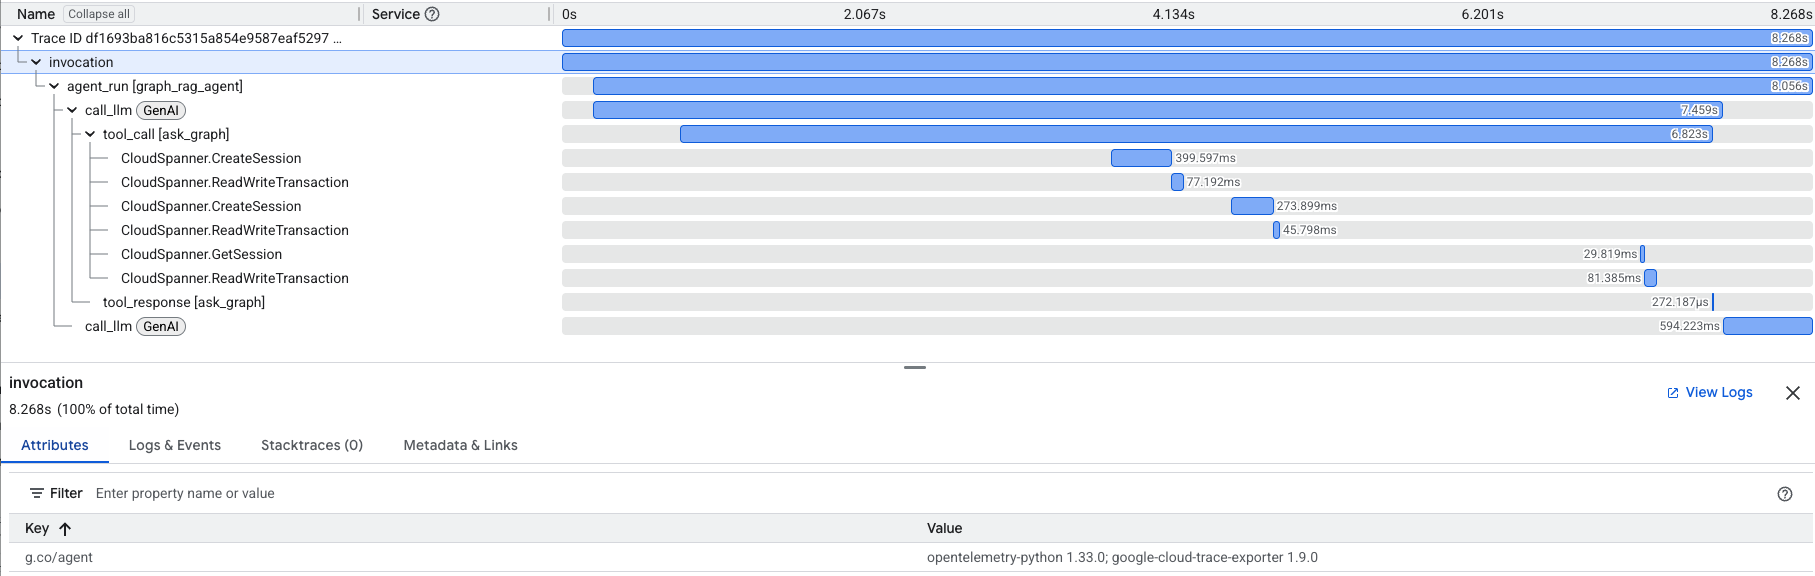

## Clean Up

*   Delete the Spanner instance
*   Delete the Vertex AI Agent Engine instance

In [ ]:
!gcloud spanner instances delete {SPANNER_INSTANCE_ID} --quiet

In [ ]:
remote_app.delete(force=True)

## What's next

* Dive deeper into [LangChain with Spanner](https://github.com/googleapis/langchain-google-spanner-python/tree/main).
* Learn more about [Spanner](https://cloud.google.com/spanner/docs/getting-started/python).
* Explore other [Spanner Graph Notebooks](https://github.com/cloudspannerecosystem/spanner-graph-notebook/blob/main/README.md).
* Learn more about [Vertex AI Engine](https://cloud.google.com/vertex-ai/generative-ai/docs/agent-engine/overview).
* Learn more about [Agent Development Kit](https://google.github.io/adk-docs/).